# Machine Learning
### Laboratory 9

### **Drug Dataset**

### **Business Understanding**

- Scenario
    - A medical division collected some data from its patients
    - All the target patients contracted the same disease
    - The therapy consists of 5 different and exclusive cures
        - Each cure depends on the patients’ conditions
- Goal
    - Define an automatic procedure for the cure assignment 

### **Data Understanding**

| Column Name                   	| Description                                                                                                     	| Type                      	|
|-------------------	|------------------------------------------------	|-----------------      	|
| ID               	| Patient’s ID                    	|  Numeric                      	|
| Age               	| Patient’s age                 	|  Numeric             	|    
| Sex                	| Patient’s gender: F or M      	|  Binary                      	|
|      BP        	|        Blood Pressure: HIGH, NORMAL or LOW       	|   Categorical                       	|
|       Cholesterol         	|   Concentration of cholesterol in the blood: NORMAL or HIGH          	|   Binary    	|
|     Na           	|    Concentration of sodium in the blood       |     Numeric                    | 
|     K          	|   Concentration of potassium in the blood        	|   Numeric                       	|
|     Drug          	|      The chosen cure: drugY, drugC, drugX, drugA, drugB            	|      Categorical                    	|

In [144]:
import pandas as pd

In [145]:
drug = pd.read_csv("drug.csv", na_values="?")
drug

,ID,Age,Sex,BP,Cholesterol,Na,K,Drug
0,1,23,F,HIGH,HIGH,0.792535,0.031258,drugY
1,2,47,M,LOW,HIGH,0.739309,0.056468,drugC
2,3,47,M,LOW,HIGH,0.697269,0.068944,drugC
3,4,28,F,NORMAL,HIGH,0.563682,0.072289,drugX
4,5,61,F,LOW,HIGH,0.559294,0.030998,drugY
...,...,...,...,...,...,...,...,...
195,196,56,F,LOW,HIGH,0.848774,0.073380,drugC
196,197,16,M,LOW,HIGH,0.743021,0.061886,drugC
197,198,52,M,NORMAL,HIGH,0.549945,NaN,drugX
198,199,23,M,NORMAL,NORMAL,0.784520,NaN,drugX


In [146]:
drug.isna().sum()

ID             0
Age            0
Sex            0
BP             0
Cholesterol    0
Na             6
K              4
Drug           0
dtype: int64

In [147]:
#null values are pretty few, for integrity's sake we can just drop those values ...
drug.dropna(inplace=True)
drug.drop("ID", axis=1,inplace=True)

In [148]:
#now I need to convert categorical variables
catv = ["Sex","BP", "Cholesterol","Drug"]
for c in catv:
    drug[c] = pd.Categorical(drug[c])

In [149]:
drug.dtypes

Age               int64
Sex            category
BP             category
Cholesterol    category
Na              float64
K               float64
Drug           category
dtype: object

Now let's check data with some cool visualizations!

In [150]:
import seaborn as sn

In [151]:
#sort the drugs by the occurence of the drug in the dataset
ordered_drugs = drug["Drug"].value_counts().index

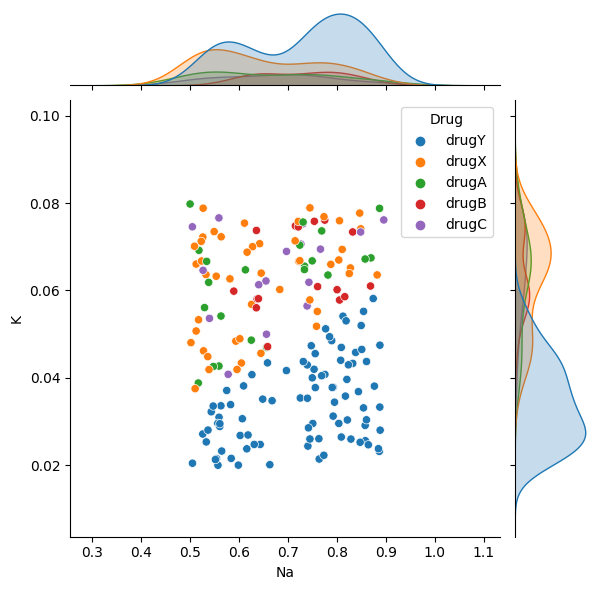

In [152]:
sn.jointplot(
    drug,
    x="Na",
    y="K",
    hue="Drug",
    hue_order=ordered_drugs
) ; 

We can already see that drugY is usually given to people with lower potassium values.

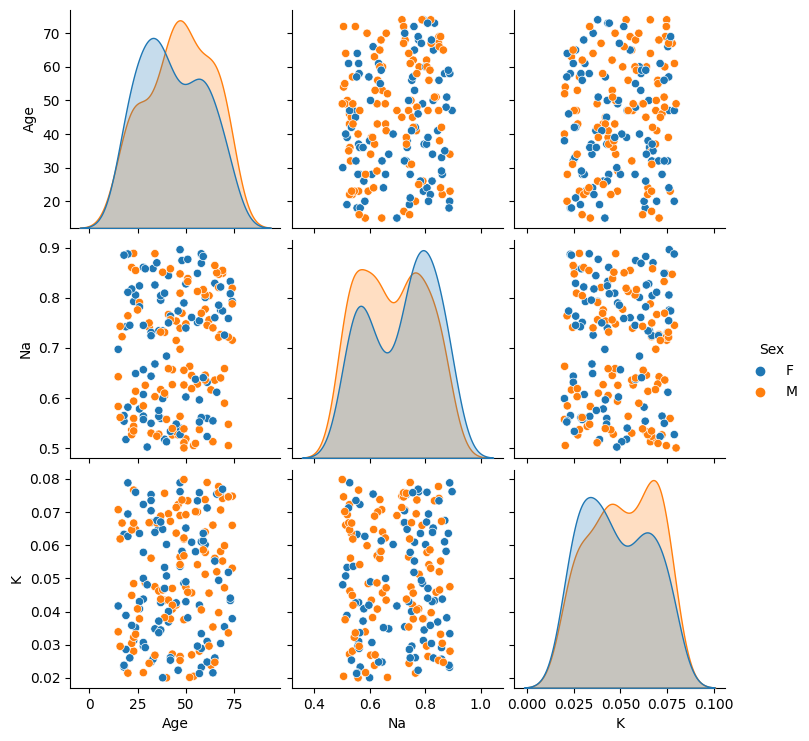

In [153]:
sn.pairplot(
    data=drug,
    hue = "Sex"
) ;

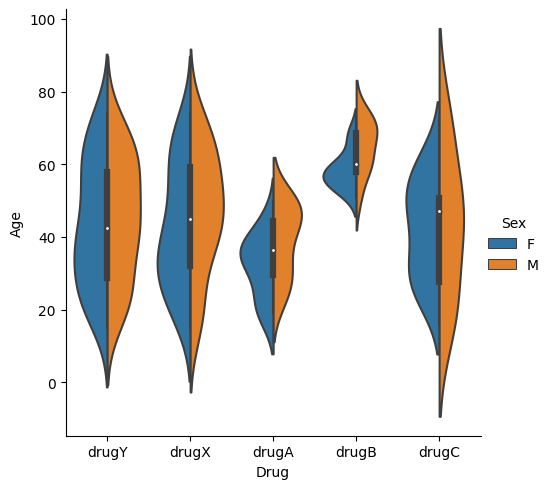

In [154]:
sn.catplot(
    drug,
    kind = "violin",
    x = "Drug",
    y = "Age",
    hue = "Sex",
    box = True,
    split = True,
    order=ordered_drugs
) ;

It is relevant to note the age distribution of drugs based on the sex.

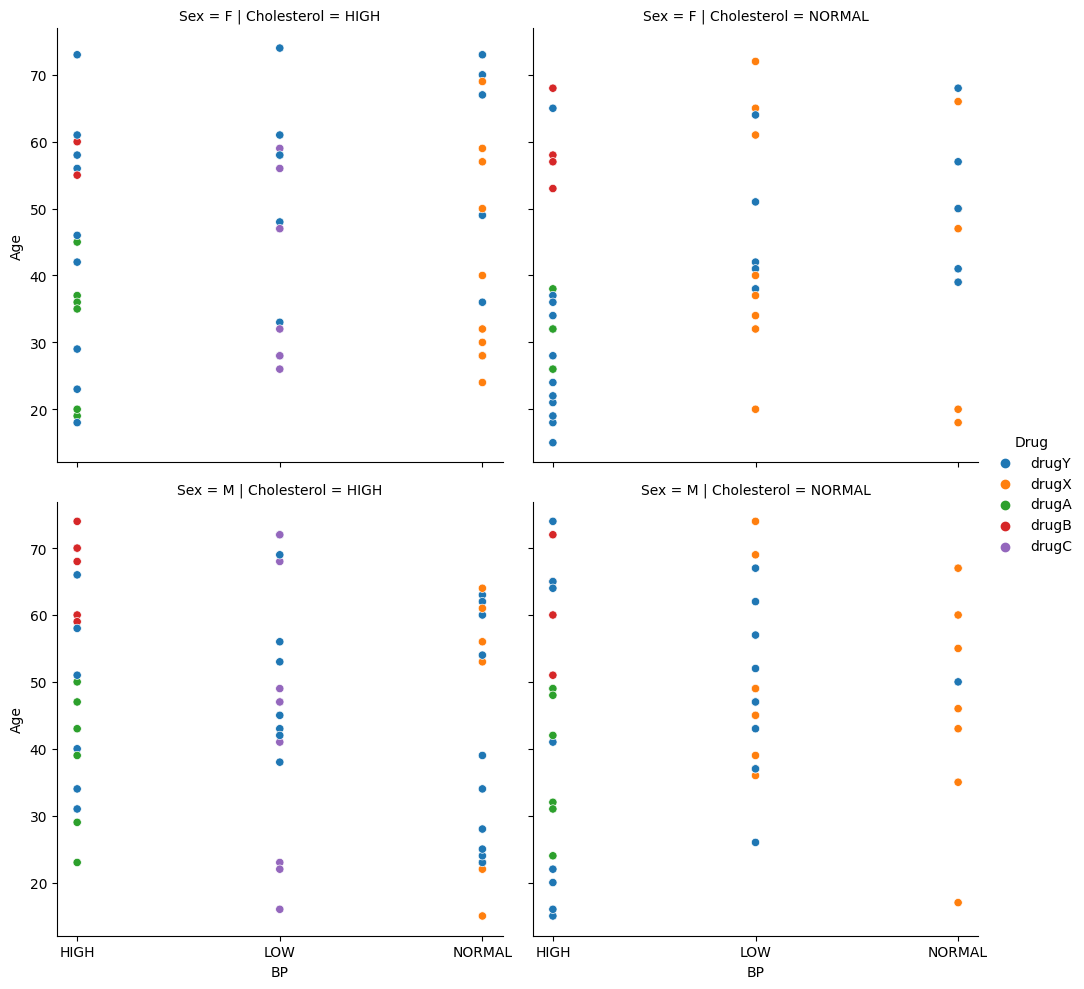

In [155]:
sn.relplot(
    data = drug,
    x = "BP",
    y = "Age",
    col = "Cholesterol",
    row = "Sex",
    hue = "Drug",
    hue_order=ordered_drugs
) ;

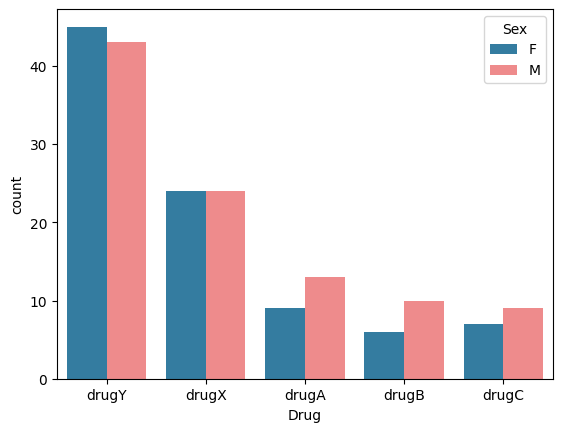

In [156]:
testpal = sn.blend_palette(["#2282b2","#ff7a7c"], n_colors=2)

sn.countplot(
    drug,
    x = "Drug",
    hue = "Sex",
    order=ordered_drugs,
    palette=testpal
) ;

Classes are not really balanced! We must check on this in the model evaluation process

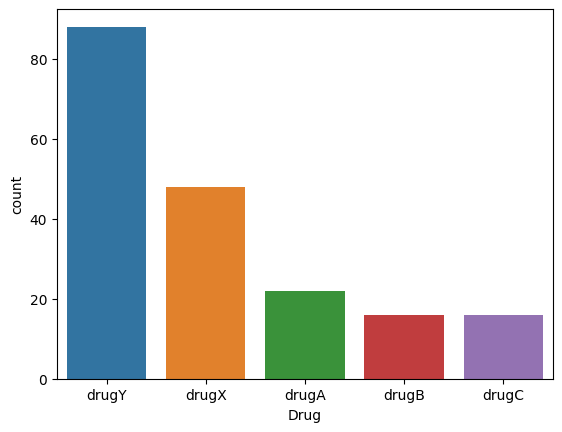

In [157]:
#Plot the count of each drug type
sn.countplot(
    drug,
    x = "Drug",
    order=ordered_drugs
) ;



### **Data Preparation**

In [158]:
#lets quickly check categories ...
drug["Cholesterol"].unique()

['HIGH', 'NORMAL']
Categories (2, object): ['HIGH', 'NORMAL']

In [159]:
drug["BP"].unique()

['HIGH', 'LOW', 'NORMAL']
Categories (3, object): ['HIGH', 'LOW', 'NORMAL']

It is required to encode BP,Sex and Cholesterol with binary variables (One Hot Encoding)

In [160]:
drug = pd.get_dummies(data=drug, columns=['BP','Sex','Cholesterol'])
drug

,Age,Na,K,Drug,BP_HIGH,BP_LOW,BP_NORMAL,Sex_F,Sex_M,Cholesterol_HIGH,Cholesterol_NORMAL
0,23,0.792535,0.031258,drugY,1,0,0,1,0,1,0
1,47,0.739309,0.056468,drugC,0,1,0,0,1,1,0
2,47,0.697269,0.068944,drugC,0,1,0,0,1,1,0
3,28,0.563682,0.072289,drugX,0,0,1,1,0,1,0
4,61,0.559294,0.030998,drugY,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
193,72,0.504820,0.074573,drugC,0,1,0,0,1,1,0
194,46,0.773569,0.022302,drugY,1,0,0,1,0,1,0
195,56,0.848774,0.073380,drugC,0,1,0,1,0,1,0
196,16,0.743021,0.061886,drugC,0,1,0,0,1,1,0


I think it's ok to test this without any standardization, then we can evaluate the models at the end and consider some further transformations if they seems to be required.

Finally, we only need to split our dataset into training and evaluation sets.

In [161]:
from sklearn.model_selection import train_test_split

In [162]:
targetDrug = drug["Drug"]
#extracting labels, will be useful for further visualization in models evaluation phase ...
lbls = targetDrug.unique()

seed = 122
testsize = 0.3 
drug.drop("Drug",axis=1, inplace=True)

x_train, x_test, y_train, y_test = train_test_split(drug,targetDrug,test_size=testsize, random_state=seed)


### **Modeling**

We are going to exploit different models, in particular:
- Decision Tree classifier
- Random Forest Classifier
- Logistic regressor

In [163]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

In [164]:
x_train

,Age,Na,K,BP_HIGH,BP_LOW,BP_NORMAL,Sex_F,Sex_M,Cholesterol_HIGH,Cholesterol_NORMAL
111,47,0.526835,0.078828,0,0,1,1,0,0,1
110,50,0.518285,0.069193,1,0,0,0,1,1,0
60,38,0.598753,0.020042,0,1,0,1,0,0,1
77,26,0.823793,0.042994,1,0,0,1,0,0,1
153,72,0.758600,0.051810,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
66,29,0.625272,0.048637,1,0,0,0,1,1,0
81,64,0.512600,0.066049,0,0,1,0,1,1,0
190,58,0.769090,0.040497,1,0,0,0,1,1,0
146,37,0.804155,0.066981,0,1,0,1,0,0,1


In [165]:
y_train

111    drugX
110    drugA
60     drugY
77     drugY
153    drugX
       ...  
66     drugA
81     drugX
190    drugY
146    drugX
162    drugX
Name: Drug, Length: 133, dtype: category
Categories (5, object): ['drugA', 'drugB', 'drugC', 'drugX', 'drugY']

In [166]:
dtmodel = DecisionTreeClassifier(random_state=seed)
dtmodel.fit(x_train,y_train) ;

In [167]:
rfmodel = RandomForestClassifier(random_state=seed)
rfmodel.fit(x_train,y_train) ;

In [168]:
logitmodel = LogisticRegression(random_state = seed, max_iter=1000) ;
logitmodel.fit(x_train,y_train) ;

#note that with default iterations size (100) and default solver (lbfgs) the model gives back a warning, suggesting to scale! 

### **Evaluation**

In [169]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [170]:
#now we can predict and evalutate the testset!
dtpredictions = dtmodel.predict(x_test)
rfpredictions = rfmodel.predict(x_test)
logitpredictions = logitmodel.predict(x_test)


In [171]:
dtmatrix = confusion_matrix(dtpredictions, y_test)
rfmatrix = confusion_matrix(rfpredictions, y_test)
logitmatrix = confusion_matrix(logitpredictions, y_test)

In [172]:
print(f"Decision Tree accuracy: {accuracy_score(dtpredictions, y_test)}")
print(f"Random Forest accuracy: {accuracy_score(rfpredictions, y_test)}")
print(f"Logistic regr accuracy: {accuracy_score(logitpredictions, y_test)}")

Decision Tree accuracy: 0.8771929824561403
Random Forest accuracy: 0.8947368421052632
Logistic regr accuracy: 0.45614035087719296


In [173]:

firstReportDt = classification_report(dtpredictions, y_test, output_dict=True)
firstReportRf = classification_report(rfpredictions, y_test, output_dict=True)

print(f"Decision Tree report: \n {classification_report(dtpredictions, y_test)}")
print(f"Random Forest report: \n {classification_report(rfpredictions, y_test)}")
print(f"Logistic regr report: \n {classification_report(logitpredictions, y_test)}")

Decision Tree report: 
               precision    recall  f1-score   support

       drugA       1.00      0.80      0.89         5
       drugB       1.00      0.86      0.92         7
       drugC       1.00      0.80      0.89         5
       drugX       0.71      1.00      0.83        10
       drugY       0.90      0.87      0.88        30

    accuracy                           0.88        57
   macro avg       0.92      0.86      0.88        57
weighted avg       0.90      0.88      0.88        57

Random Forest report: 
               precision    recall  f1-score   support

       drugA       1.00      0.80      0.89         5
       drugB       1.00      0.86      0.92         7
       drugC       1.00      1.00      1.00         4
       drugX       0.71      1.00      0.83        10
       drugY       0.93      0.87      0.90        31

    accuracy                           0.89        57
   macro avg       0.93      0.91      0.91        57
weighted avg       0.91      

In [174]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [175]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(
    go.Heatmap(z=confusion_matrix(dtpredictions,y_test),
                                    x=lbls,
                                    y=lbls
                                    ),
    row=1,
    col=1
)

fig.add_trace(
    go.Heatmap(z=confusion_matrix(rfpredictions,y_test),
                                    x=lbls,
                                    y=lbls
                                    ),
    row=1,
    col=2
)

fig.add_trace(
    go.Heatmap(z=confusion_matrix(logitpredictions,y_test),
                                    x=lbls,
                                    y=lbls
                                    ),
    row=1,
    col=3
)

fig.update_layout(
    margin=dict(l=10, r=10, t=10, b=10),
    paper_bgcolor="lemonchiffon",
)

fig.update_yaxes(ticksuffix = " ") 

fig.show()

Even if with problems, the graph above shows that there are a few problems with the logit model. Probably it is due to the fact that I didn't scale the training set (warning given during training)
However, I've got a couple of solid models, so it is not needed to further improve the logit one.

### Remake of the confusion matrix

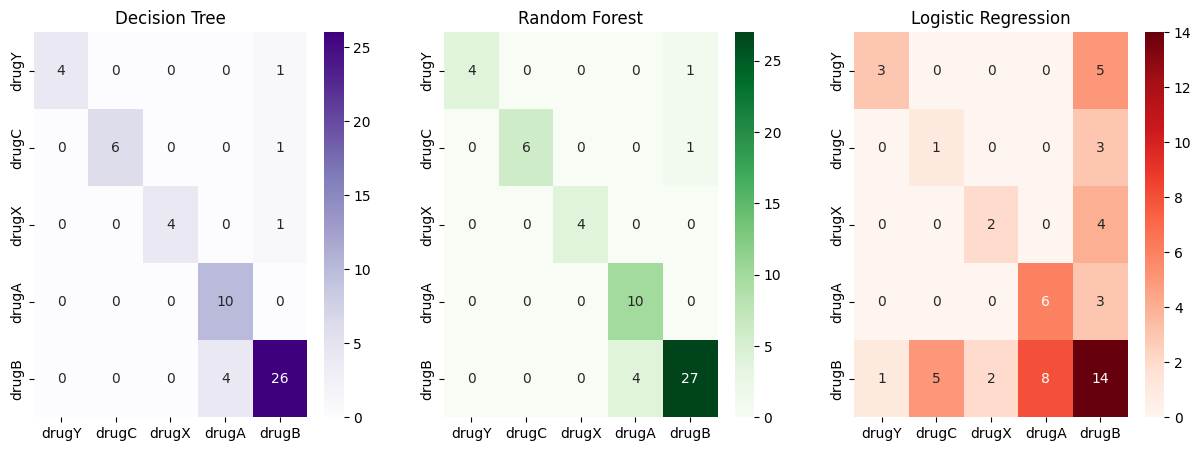

In [176]:
#make confusion matrix without plotly

import matplotlib.pyplot as plt
import seaborn as sn

fig, ax = plt.subplots(1,3, figsize=(15,5))

sn.heatmap(confusion_matrix(dtpredictions,y_test), annot=True, ax=ax[0], xticklabels=lbls, yticklabels=lbls, cmap="Purples")
sn.heatmap(confusion_matrix(rfpredictions,y_test), annot=True, ax=ax[1], xticklabels=lbls, yticklabels=lbls, cmap="Greens")
sn.heatmap(confusion_matrix(logitpredictions,y_test), annot=True, ax=ax[2], xticklabels=lbls, yticklabels=lbls, cmap="Reds")

ax[0].set_title("Decision Tree")
ax[1].set_title("Random Forest")
ax[2].set_title("Logistic Regression")

plt.show()

### How to make the model better?

<Axes: >

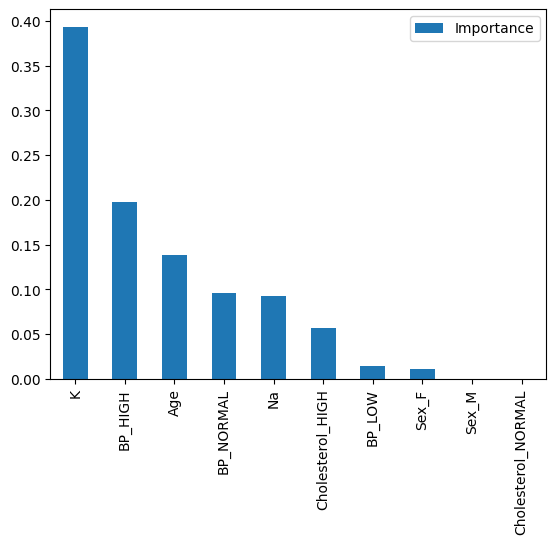

In [177]:
#Check which features are the most important for the model and visualize with a barplot
importances = dtmodel.feature_importances_
importances = pd.DataFrame(importances, index=x_train.columns, columns=["Importance"])
importances

#bar plot
importances.sort_values(by="Importance", ascending=False).plot(kind="bar")

In [178]:
#now we can try to improve the model by removing the least important features

features = importances[importances["Importance"] > 0.05].index
features

x_train = x_train[features]
x_test = x_test[features]

dtmodel = DecisionTreeClassifier(random_state=seed)
dtmodel.fit(x_train,y_train) ;

rfmodel = RandomForestClassifier(random_state=seed)
rfmodel.fit(x_train,y_train) ;




In [179]:
#evalutate the testset!

dtpredictions = dtmodel.predict(x_test)
rfpredictions = rfmodel.predict(x_test)

dtmatrix = confusion_matrix(dtpredictions, y_test)
rfmatrix = confusion_matrix(rfpredictions, y_test)

print(f"Decision Tree accuracy: {accuracy_score(dtpredictions, y_test)}")
print(f"Random Forest accuracy: {accuracy_score(rfpredictions, y_test)}")

Decision Tree accuracy: 0.8771929824561403
Random Forest accuracy: 0.9122807017543859


In [180]:
secondReportDt = classification_report(dtpredictions, y_test, output_dict=True)
secondReportRf = classification_report(rfpredictions, y_test, output_dict=True)


print(f"Decision Tree report: \n {classification_report(dtpredictions, y_test)}")
print(f"Random Forest report: \n {classification_report(rfpredictions, y_test)}")

Decision Tree report: 
               precision    recall  f1-score   support

       drugA       1.00      0.80      0.89         5
       drugB       1.00      0.86      0.92         7
       drugC       1.00      0.80      0.89         5
       drugX       0.71      1.00      0.83        10
       drugY       0.90      0.87      0.88        30

    accuracy                           0.88        57
   macro avg       0.92      0.86      0.88        57
weighted avg       0.90      0.88      0.88        57

Random Forest report: 
               precision    recall  f1-score   support

       drugA       1.00      0.80      0.89         5
       drugB       1.00      0.86      0.92         7
       drugC       1.00      1.00      1.00         4
       drugX       0.79      1.00      0.88        11
       drugY       0.93      0.90      0.92        30

    accuracy                           0.91        57
   macro avg       0.94      0.91      0.92        57
weighted avg       0.92      

## Confusion Matrixes

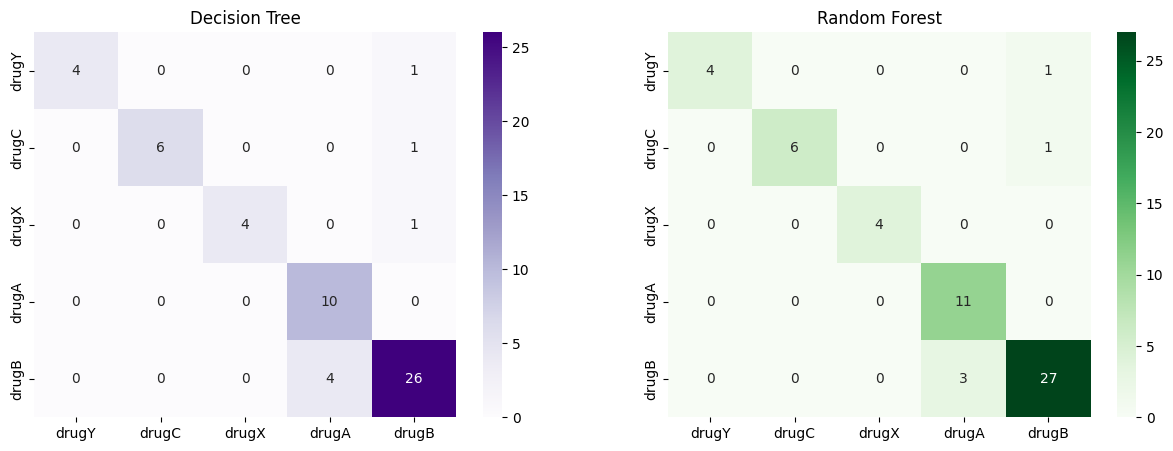

In [189]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sn.heatmap(confusion_matrix(dtpredictions,y_test), annot=True, ax=ax[0], xticklabels=lbls, yticklabels=lbls, cmap="Purples")
sn.heatmap(confusion_matrix(rfpredictions,y_test), annot=True, ax=ax[1], xticklabels=lbls, yticklabels=lbls, cmap="Greens")

ax[0].set_title("Decision Tree")
ax[1].set_title("Random Forest")

plt.show()


Now let's compare the reports

In [ ]:
print(f"First report Decision Tree {firstReportDt}")
print(f"Second report Decision Tree {secondReportDt}")

print(f"First report Random Forest {firstReportRf}")
print(f"Second report Random Forest {secondReportRf}")

First report Decision Tree {'drugA': {'precision': 1.0, 'recall': 0.8, 'f1-score': 0.888888888888889, 'support': 5}, 'drugB': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 7}, 'drugC': {'precision': 1.0, 'recall': 0.8, 'f1-score': 0.888888888888889, 'support': 5}, 'drugX': {'precision': 0.7142857142857143, 'recall': 1.0, 'f1-score': 0.8333333333333333, 'support': 10}, 'drugY': {'precision': 0.896551724137931, 'recall': 0.8666666666666667, 'f1-score': 0.8813559322033899, 'support': 30}, 'accuracy': 0.8771929824561403, 'macro avg': {'precision': 0.9221674876847292, 'recall': 0.8647619047619048, 'f1-score': 0.8831087932782848, 'support': 57}, 'weighted avg': {'precision': 0.8954282257367557, 'recall': 0.8771929824561403, 'f1-score': 0.8793761166642523, 'support': 57}}
Second report Decision Tree {'drugA': {'precision': 1.0, 'recall': 0.8, 'f1-score': 0.888888888888889, 'support': 5}, 'drugB': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1

Looks like the Random Forest got better results.

Therefore, removing Age probably is not a good way to improve the model, since from the graphs we could see something from it. Probably with this pruning we can face some overfitting